# Plotting an L-Curve
This lesson shows how to plot an L-curve to estimate the best value for the regularization parameter. First, we need to add the parent folder to the path to use all out packages

In [1]:
import sys
sys.path
sys.path.append("..")

Now, we can import everything as usual

In [2]:
# numpy imports and settings
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=500, edgeitems=10)
# example imports
import example
from utils import root_utils
# plotting imports
import pylab as plt
%matplotlib inline
# Set up logger to print in the notebook
import sys, logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)

Welcome to JupyROOT 6.23/01


# Initialization
Initialize data

In [3]:
# toy generation
nbins = 40
# Generate initial distribution and response matrix
xini, bini, Adet = example.maker.generate_initial_samples(nbins)
# Generate test distribution (what is measured in the experiment)
datatrue, data, statcov = example.maker.generate_test_samples(nbins)

# Map ROOT objects to numpy arrays
xinipy, xinipy_edges = root_utils.histogram_to_python(xini)
binipy, binipy_edges = root_utils.histogram_to_python(bini)
Adetpy_events, Adetpy_edges = root_utils.histogram_to_python(Adet)

# Data
datapy, datapy_edges = root_utils.histogram_to_python(data)
# Data "truth" distribution to test the unfolding
datatruepy, datatruepy_edges = root_utils.histogram_to_python(datatrue)
# Statistical covariance matrix
statcovpy, statcovpy_edges = root_utils.histogram_to_python(statcov)
# Turn Adetpy from number of events to probabilities (to use it with quantum annealing)
Adetpy = np.true_divide(Adetpy_events, xinipy, where=xinipy!=0)

# Unfold with annealing
Unflold with simulated classical or quantum annealing with a range of regularization factors to plot the L-curve

In [10]:
# annealing unfolder
from unfolders.annealing import QUBOUnfolder, backends
# Choose backend
annealer = backends.SimulatedAnnealingBackend(50)

In [22]:
factors = np.arange(0.001, 0.5, 0.005)
print(factors.shape)

(100,)


In [23]:
# Define factors to try
factors = np.arange(0.001, 0.5, 0.005)
# Create arrays to store info
norms = np.zeros(shape=factors.shape)
ress = np.zeros(shape=factors.shape)
# Unfold the normal histograms for each factor
for i, factor in enumerate(factors):
    # adding +1 to avoid division over zero
    unfolder = QUBOUnfolder(
        datatruepy+1, Adetpy, datapy, n_bits=4, weight_regularization=factor
    )
    # Unfold
    x_unfolded = unfolder.solve(annealer)
    # Get elements to plot
    norm, res = unfolder.compute_energy(x_unfolded)
    res = res / factor
    # Store in the arrays
    norms[i] = norm
    ress[i] = res

# Plot L-Curve

Text(0, 0.5, '$log|Dx|^2$')

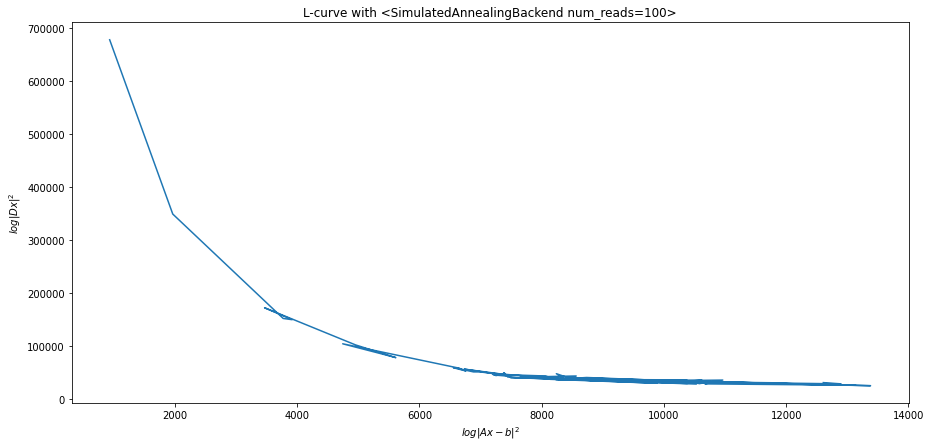

In [25]:
plt.figure(figsize=(15, 7))
plt.plot(norms, ress)

plt.title(f"L-curve with {annealer}")
plt.xlabel("$log|Ax-b|^2$")
plt.ylabel("$log|Dx|^2$")